<a href="https://colab.research.google.com/github/Vargol/StableDiffusionColabs/blob/main/SD3/Stable_Diffusion_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy peft

In [2]:
import mediapy as media
import random
import sys
import torch
import gc
import time

from diffusers import StableDiffusion3Pipeline

pipe = None
pipe_t = None
device = "cuda"

styles = {
"Enhance" : {
"Positive" : "breathtaking {prompt} . award-winning, professional, highly detailed",
"Negative" : "ugly, deformed, noisy, blurry, distorted, grainy",
},
"Anime" : {
"Positive" : "anime artwork {prompt} . anime style, key visual, vibrant, studio anime,  highly detailed",
"Negative" : "photo, deformed, black and white, realism, disfigured, low contrast",
},
"Photographic" : {
"Positive" : "cinematic photo {prompt} . 35mm photograph, film, bokeh, professional, 4k, highly detailed",
"Negative" : "drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly",
},
"Digital art" : {
"Positive" : "concept art {prompt} . digital artwork, illustrative, painterly, matte painting, highly detailed",
"Negative" : "photo, photorealistic, realism, ugly",
},
"Comic book" : {
"Positive" : "comic {prompt} . graphic illustration, comic art, graphic novel art, vibrant, highly detailed",
"Negative" : "photograph, deformed, glitch, noisy, realistic, stock photo",
},
"Fantasy art" : {
"Positive" : "ethereal fantasy concept art of  {prompt} . magnificent, celestial, ethereal, painterly, epic, majestic, magical, fantasy art, cover art, dreamy",
"Negative" : "photographic, realistic, realism, 35mm film, dslr, cropped, frame, text, deformed, glitch, noise, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, sloppy, duplicate, mutated, black and white",
},
"Analog film" : {
"Positive" : "analog film photo {prompt} . faded film, desaturated, 35mm photo, grainy, vignette, vintage, Kodachrome, Lomography, stained, highly detailed, found footage",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Neonpunk" : {
"Positive" : "neonpunk style {prompt} . cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, ultra detailed, intricate, professional",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Isometric" : {
"Positive" : "isometric style {prompt} . vibrant, beautiful, crisp, detailed, ultra detailed, intricate",
"Negative" : "deformed, mutated, ugly, disfigured, blur, blurry, noise, noisy, realistic, photographic",
},
"Lowpoly" : {
"Positive" : "low-poly style {prompt} . low-poly game art, polygon mesh, jagged, blocky, wireframe edges, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Origami" : {
"Positive" : "origami style {prompt} . paper art, pleated paper, folded, origami art, pleats, cut and fold, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Line art" : {
"Positive" : "line art drawing {prompt} . professional, sleek, modern, minimalist, graphic, line art, vector graphics",
"Negative" : "anime, photorealistic, 35mm film, deformed, glitch, blurry, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, mutated, realism, realistic, impressionism, expressionism, oil, acrylic",
},
"Craft clay" : {
"Positive" : "play-doh style {prompt} . sculpture, clay art, centered composition, Claymation",
"Negative" : "sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Cinematic" : {
"Positive" : "cinematic film still {prompt} . shallow depth of field, vignette, highly detailed, high budget Hollywood movie, bokeh, cinemascope, moody, epic, gorgeous, film grain, grainy",
"Negative" : "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured",
},
"3d-model" : {
"Positive" : "professional 3d model {prompt} . octane render, highly detailed, volumetric, dramatic lighting",
"Negative" : "ugly, deformed, noisy, low poly, blurry, painting",
},
"Pixel art" : {
"Positive" : "pixel-art {prompt} . low-res, blocky, pixel art style, 8-bit graphics",
"Negative" : "sloppy, messy, blurry, noisy, highly detailed, ultra textured, photo, realistic",
},
"Texture" : {
"Positive" : "texture {prompt} top down close-up",
"Negative" : "ugly, deformed, noisy, blurry",
}
}

aspects = {
"12:5" :  { 'x' : 1536  , 'y' :  640 },
"7:4" :   { 'x' : 1344  , 'y' :  768 },
"19:13" : { 'x' : 1216  , 'y' :  832  },
"9:7" :   { 'x' : 1152 , 'y' : 896  },
"1:1" :   { 'x' : 1024 , 'y' : 1024 },
"7:9" :   { 'x' : 896  , 'y' : 1152  },
"13:19" : { 'x' : 832  , 'y' :  1216 },
"4:7" :   { 'x' : 768  , 'y' :  1344 },
"5:12" :  { 'x' : 640  , 'y' :  1536 }
}






/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


The next cell is where you set you parameters and run Stable Diffusion.
The cell is re-runable, so you can edit the parameters and run without recreating the environment

Note the free tier can't hold the base and refiner models in VRAM at the same time so if the refiner is userd it does the base run image_count times followed by the refiner run image_count times, it uses a seperate generator for each run of the base model so they can be passed to the refiner and allow you to regenerate an image using the prompt, style and seed (requires code changes).

In [4]:
prompt = "Near a tree by a river There's a hole in the ground Where an old man of Aran Goes around and around And his mind is a beacon In the veil of the night For a strange kind of fashion There's a wrong and a right But he'll never, never fight over you"
style = "Photographic"
aspect = "1:1"

orig_prompt = prompt
prompt = styles[style]["Positive"].replace("{prompt}", prompt)
negative_prompt = styles[style]["Negative"]

pipe = None
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

with torch.inference_mode():
  if pipe_t is None:
    pipe_t = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers",  transformer=None,
                                                  torch_dtype=torch.float16
  )
  pipe_t.to(device)

  (prompt_embeds, negative_prompt_embeds, pooled_prompt_embeds, negative_pooled_prompt_embeds, ) = pipe_t.encode_prompt(
      prompt=prompt, prompt_2=None, prompt_3=None,
      negative_prompt=negative_prompt)

  pipe_t = None

  gc.collect()
  torch.cuda.empty_cache()
  gc.collect()
  torch.cuda.empty_cache()


Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Token indices sequence length is longer than the specified maximum sequence length for this model (79 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['highly detailed']
Token indices sequence length is longer than the specified maximum sequence length for this model (79 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['highly detailed']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. 35mm photograph, film, bokeh, professional, 4k, highly detailed']


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



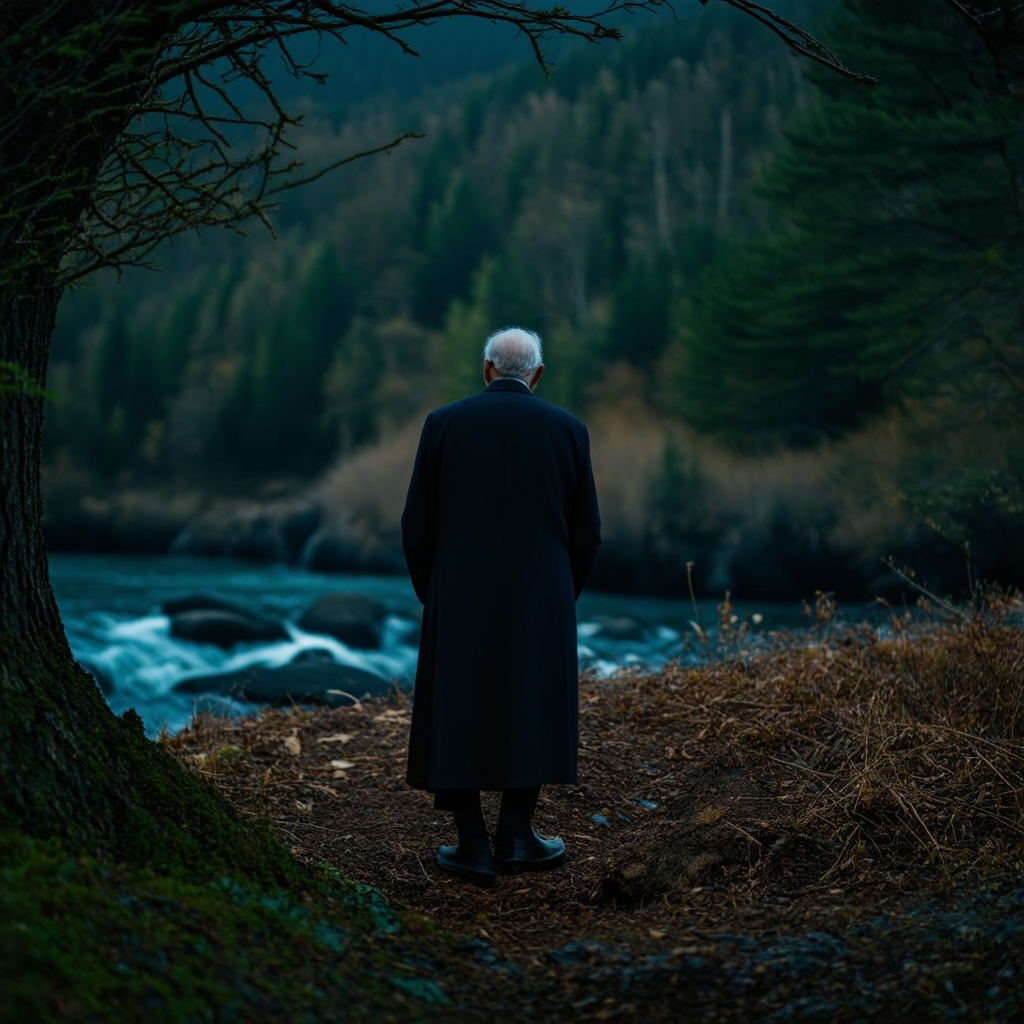

  0%|          | 0/28 [00:00<?, ?it/s]


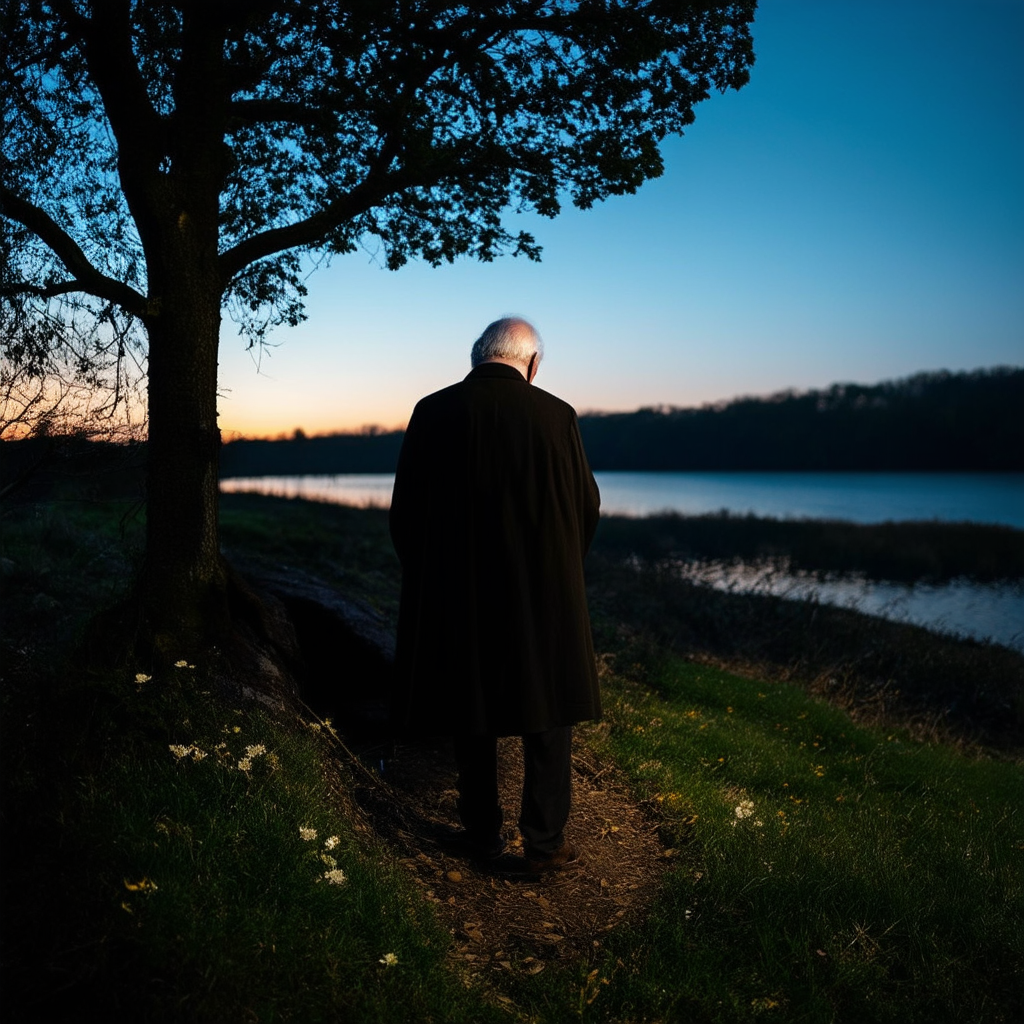

  0%|          | 0/28 [00:00<?, ?it/s]


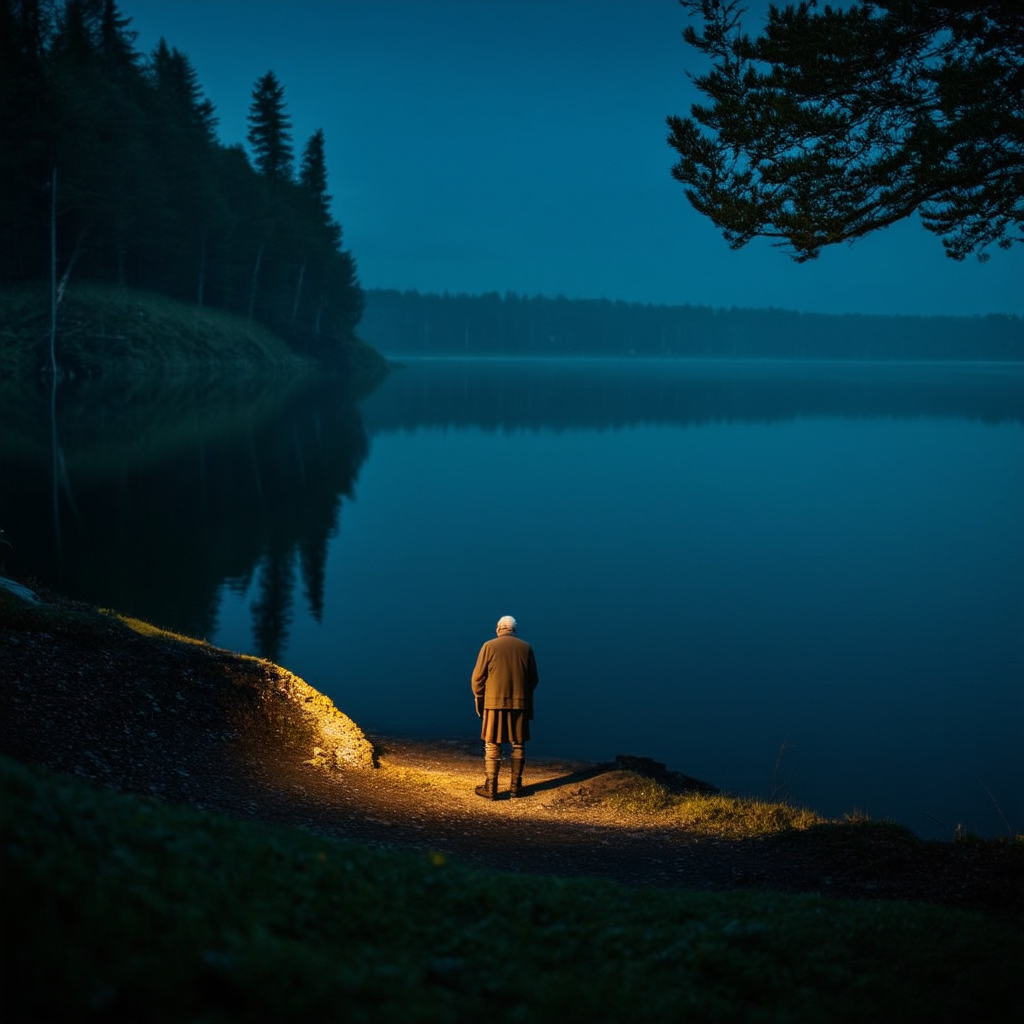

In [5]:
image_count = 3
if pipe is None:

  pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers",
                                                  text_encoder=None, tokenizer=None,
                                                  text_encoder_2=None, tokenizer_2=None,
                                                  text_encoder_3=None, tokenizer_3=None,
                                                  torch_dtype=torch.float16)
  pipe.to(device)

for i in range(image_count):

  seed = random.randint(0, sys.maxsize)
  generator =  torch.Generator(device).manual_seed(seed);

  image = pipe(
      prompt=None,
      prompt_embeds=prompt_embeds,
      pooled_prompt_embeds=pooled_prompt_embeds,
      negative_prompt_embeds=negative_prompt_embeds,
      negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
      num_inference_steps=28,
      height=aspects[aspect]['x'],
      width=aspects[aspect]['y'],
      guidance_scale=7.0,
      generator=generator
  ).images[0]

  image.save(f"sd3_{seed}.png")
  media.show_image(image)

